## Scope:

Single-cell imaging data is often noisy. In order to make an accurate estimate of the active kinase concentration, we first want to remove outlier cells from the data set. This example notebook will walk you through how to interact with your data set and remove outlier data using the functions provided. We will clean the three data sets that we need using this process.

This method relies heavily on Python classes. The documentation is [here](https://docs.python.org/2.7/tutorial/classes.html) for users who wish to learn more about how classes work.

First, we need to import the necessary Python packages to access all of the functions we need:

In [1]:
from __future__ import division
from covertrace.data_array import Sites, DataArray
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import abspath, dirname, join
%matplotlib inline

Next, we import the functions that will help us access and manipulate the data:

In [2]:
from covertrace import ops_filter
from covertrace import ops_plotter
from covertrace import ops_bool

Finally, we save the location of the data as a variable that we can access later:

In [3]:
data_folder = '/home/output/'

### Clean the first dataset: IL1$\beta$ stimulation

The *Sites* object provides a convenient interface for handling complex live-cell data. Please take a look at the Github repository for details.
Briefly, it stores all of the single cell traces for various properties and conditions for multiple positions. 

Let's first look at the dataset where the JNK KTR was activated with IL1$\beta$. We load the position we want and specify the experimental conditions by setting the variables *sub_folders* and *conditions*. We load these data by instantiating a *Sites* object which we name *sites*. The file name 'df.npz' is the default file name from running *covertrack*, but modified data sets can be saved under different file names and loaded using this command.

In [4]:
parent_folder = join(data_folder, 'IL1B')
sub_folders = ['Pos005', 'Pos006', 'Pos007', 'Pos008',]
conditions = ['IL1B', 'IL1B', 'IL1B', 'IL1B']
sites = Sites(parent_folder, sub_folders, conditions, file_name='df.npz')

The *sites* object stores the data from each position, so typing *sites.Pos005* allows you to access various data for that specific position.   
Here, for all the positions, we set the time stamps from 0 min to 147.5 min at 2.5 min intervals.

In [5]:
for key, site in sites.iteritems():
    site.time = np.arange(0, 150, 2.5)  # in minutes
sites.add_median_ratio()

*Sites* class will allow ops_\* functions to be applied to all the positions automatically.  
The functions most often used are those in the *ops_filter*, *ops_bool*, and *ops_plotter* modules that we imported above.  In this case, we use *plot_tsplot function* from the *ops_plotter* module.

(Note: type `ops_plotter.plot_tsplot?` to see a description of what this function does.)

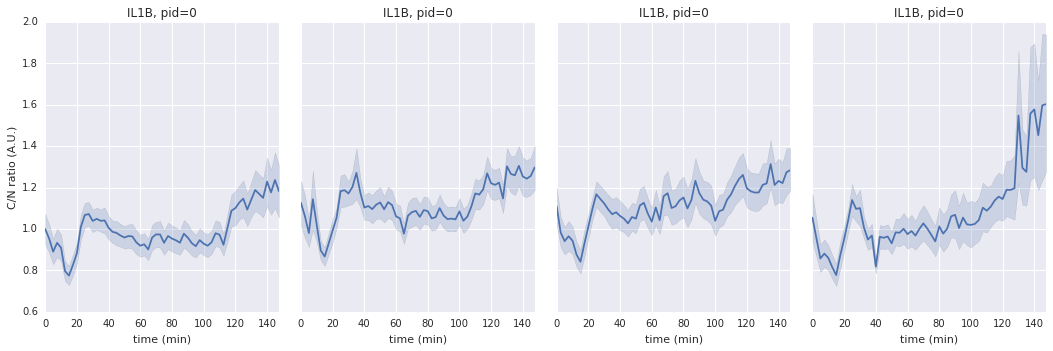

In [6]:
fig, axes = ops_plotter.plot_tsplot(sites['cyto', 'TRITC', 'median_ratio'])
[ax.set_xlabel('time (min)') for ax in axes];
axes[0].set_ylabel('C/N ratio (A.U.)')

Here is the plot generated by *sites.iterate(plot_tsplot)*. It is a plot of the median cytoplasmic to nuclear (C/N) ratio of the TRITC signal. You can see the activation of JNK KTR upon IL1$\beta$ stimulation.  

Now take a look at the single-cell traces using the function *ops_plotter.plot_all*. 

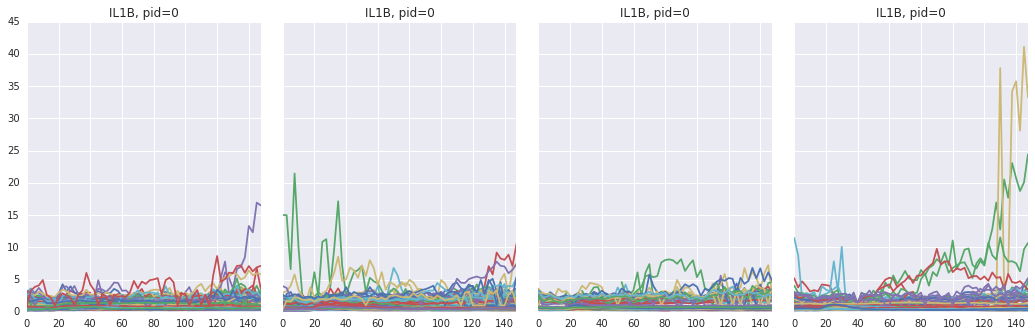

In [7]:
fig, axes = ops_plotter.plot_all(sites['cyto', 'TRITC', 'median_ratio'])

You can see that the single-cell traces are much noisier than the averaged traces above. 

One typical cause of outliers is having cells that express very low amounts of the reporter. Let's take a look at the nuclear signal intensity to identify these cells. We use *sites.set_state* to select the property and then use *sites.iterate* to plot.

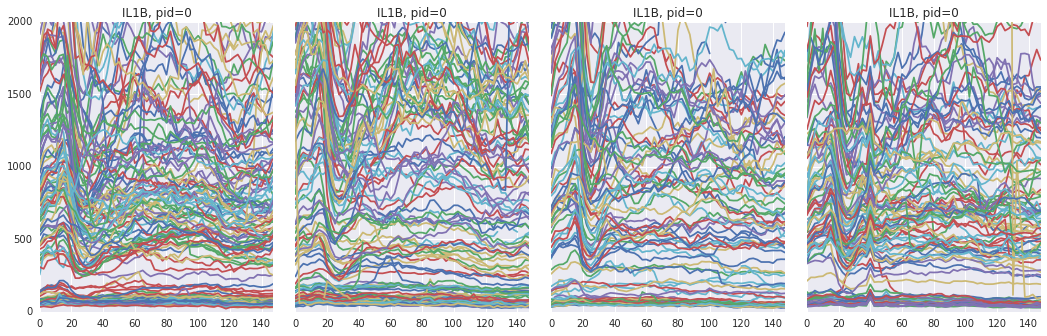

In [8]:
fig, axes = ops_plotter.plot_all(sites['nuc', 'TRITC', 'median_intensity'])
[ax.set_ylim([0, 2000]) for ax in axes];

Indeed, you can see two distinct populations in terms of the reporter levels in the nuclei. We want to exclude the cells that aren't expressing high amounts of the reporter. The process for doing this is first to assign a 'Property ID' (*pid*) to these cells and then remove all cells with that *pid*.

Let's assign *pid = 1* to all cells with a median intensity less than 500. We use **ops_bool.filter_frames_by_range** to mark frames with a median intensity less than the specified lower bound. All *ops_bool* functions are used to mark frames that meet certain criteria, in this case having a value lower than a cutoff threshold.

Now when weplot data, it separates the plots based on *pid*.

In [9]:
ops_bool.filter_frames_by_range(sites['nuc', 'TRITC', 'median_intensity'], LOWER=250)

We can also check that cells with *pid = 1* have a noisier C/N ratio. We'll plot all position and *pid* combinations to see this.
  
*Sites* class has *canvas* as an attribute, and this can be used to modify subplot configuration. Set a number of rows to 2.

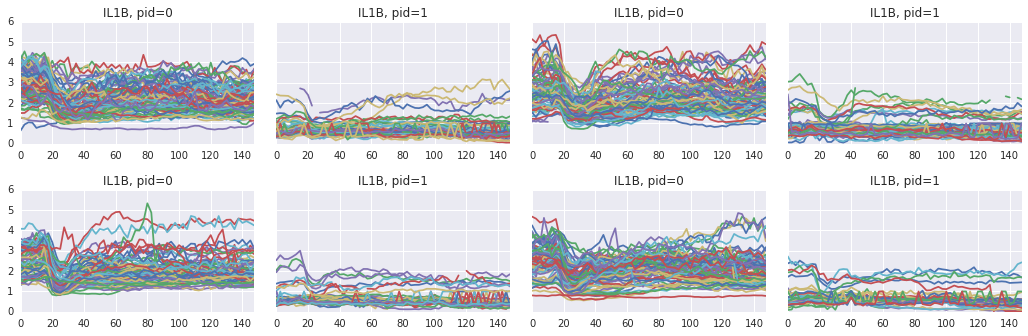

In [11]:
sites.canvas.num_row = 2
fig, axes = ops_plotter.plot_all(sites['nuc', 'TRITC', 'median_ratio'])

Notice that the plots above with *prop = 1* in their title have a much noisier C/N ratio.

We can now remove the cells with *pid = 1* and confirm that they were removed from the data set. The function *sites.drop_prop* removes all cells containing the given *pid*. 

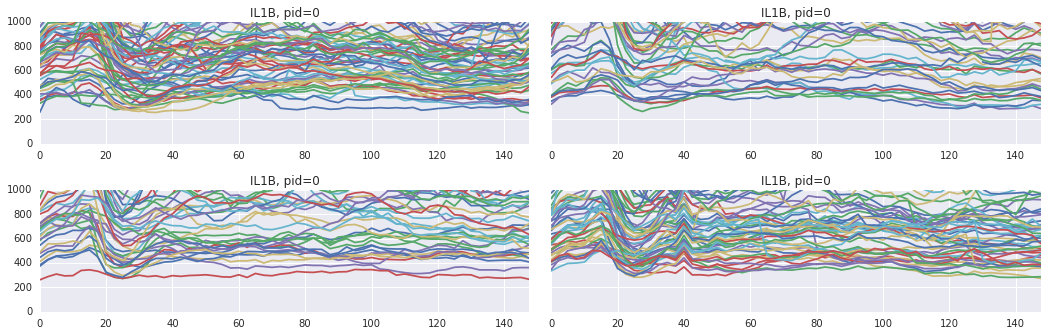

In [12]:
sites.drop_prop(1)
fig, axes = ops_plotter.plot_all(sites['nuc', 'TRITC', 'median_intensity'])
[ax.set_ylim([0, 1000]) for ax in axes];

Another frequent cause of noisy data is errors in the image segmentation. Particularly when cells are confluent, it is sometimes hard to segment many pixels from the cytoplasm, thus the data extracted may not be reliable. Therefore, we remove cells that have too few pixels. 

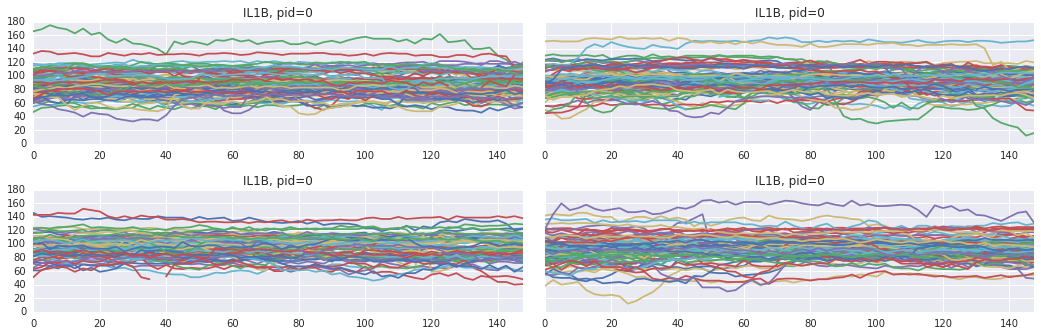

In [13]:
fig, axes = ops_plotter.plot_all(sites['cyto', 'TRITC', 'area'])

In [14]:
ops_bool.filter_frames_by_range(sites['cyto', 'TRITC', 'area'], LOWER=60, UPPER=130)
sites.drop_prop(1)

Run a similar operation for nuclear area. Too small or too big nuclei often mean segmentation error or unhealthy cells.

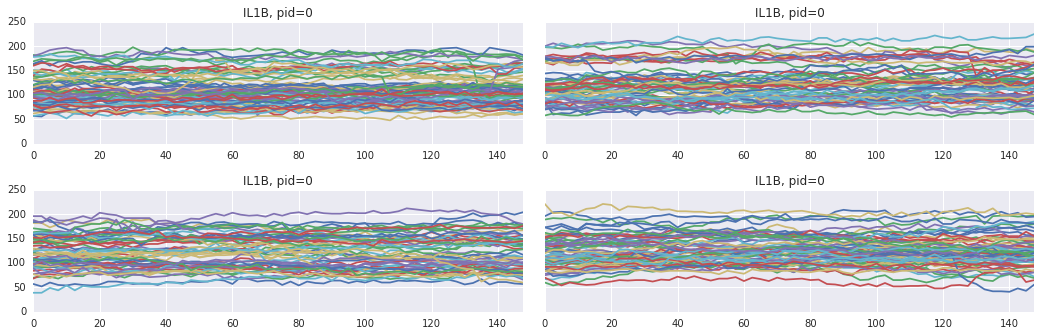

In [15]:
fig, axes = ops_plotter.plot_all(sites['nuc', 'TRITC', 'area'])

In [16]:
ops_bool.filter_frames_by_range(sites['nuc', 'TRITC', 'area'], LOWER=50, UPPER=200)
sites.drop_prop(1)

Another frequent cause of noise is a sudden change in nuclear area. This may be caused by cell death, cell division, or mis-segmentation. Use the same process as above to remove cells with a sudden nuclear area change.  
Let's filter out cells if nuclear area changes more than 15 pixels. The function *ops_bool.filter_frames_by_diff* can be used to find cells with sudden area changes.

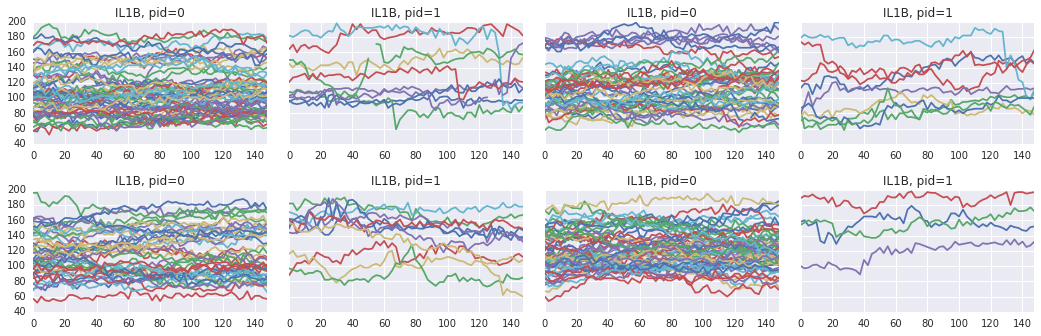

In [17]:
ops_bool.filter_frames_by_diff(sites['nuc', 'TRITC', 'area'], THRES=15)
fig, axes = ops_plotter.plot_all(sites['nuc', 'TRITC', 'area']);

In [18]:
sites.drop_prop(1)

When the signal-to-noise ratio is low, noise in the measurements can drastically affect the normalization of normalize nuclear intensity by cytoplasmic intensity.
For simplicity, let's exclude cells which have expression levels outside of the 10th and 95th percentile in either nucleus or cytoplasm. This can be accomplished with the function *ops_bool.filter_frames_by_percentile_stats*.  
We also use ops_bool.cut_short_traces to remove cells containing NaN.

In [19]:
ops_bool.filter_frames_by_percentile_stats(sites['cyto', 'TRITC', 'median_intensity'], LOWER=10, UPPER=95)
ops_bool.filter_frames_by_percentile_stats(sites['nuc', 'TRITC', 'median_intensity'], LOWER=10, UPPER=95)
ops_bool.cut_short_traces(sites['cyto', 'TRITC', 'median_ratio'], MINFRAME=60)
sites.drop_prop(1)

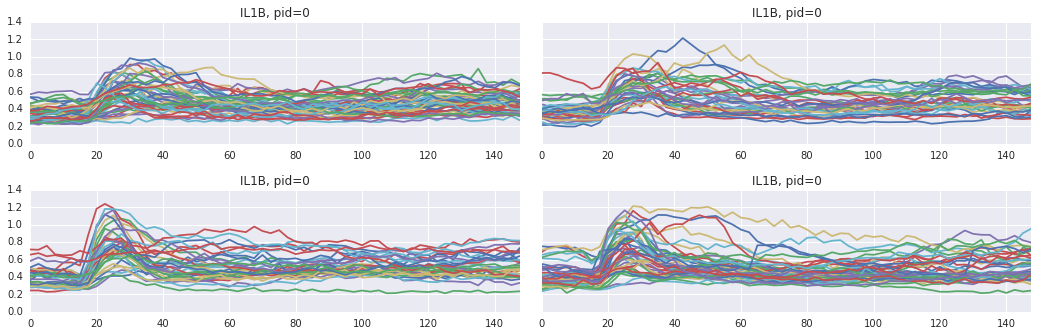

In [20]:
ops_plotter.plot_all(sites['cyto', 'TRITC', 'median_ratio']);

The cleaned dataset can now be saved as *df_cleaned.npz* by using *sites.save*.

In [21]:
sites.save('df_cleaned.npz')

Now the single-cell traces are significantly less noisy. 
You can use the Bokeh notebook below to zoom and pan to investigate the data closer.

In [22]:
import bokeh.io
bokeh.io.output_notebook()
import bokeh.mpl
import bokeh.plotting

Loading BokehJS ...

/opt/conda/lib/python2.7/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: MPL compatibility can no longer be successfully maintained, and is now deprecated. All MPL compat functions will be removed completely on the release of Bokeh 1.0. See http://bokeh.pydata.org/en/latest/docs/releases/0.12.5.html for more information
  warn(message)


In [23]:
fig, axes = ops_plotter.plot_all(sites['cyto', 'TRITC', 'median_ratio'])
fig.set_size_inches((4, 4))
bokeh.plotting.show(bokeh.mpl.to_bokeh())  # Add this line after you plot

**Congratulations!!!** We've gone through one data cleaning example.

This is just one example for cleaning this data set, and different experiments require different processes.  As you can see, data cleaning entails iterating through visualization and filtering steps for multiple wells.

### Cleaning the YFP channel

We also need to do some cleaning on the YFP channel.  
In this experiment, cells express both the non-responsive JNK KTR AE mutant in the YFP channel in addition to the wild-type JNK KTR in the TRITC channel.

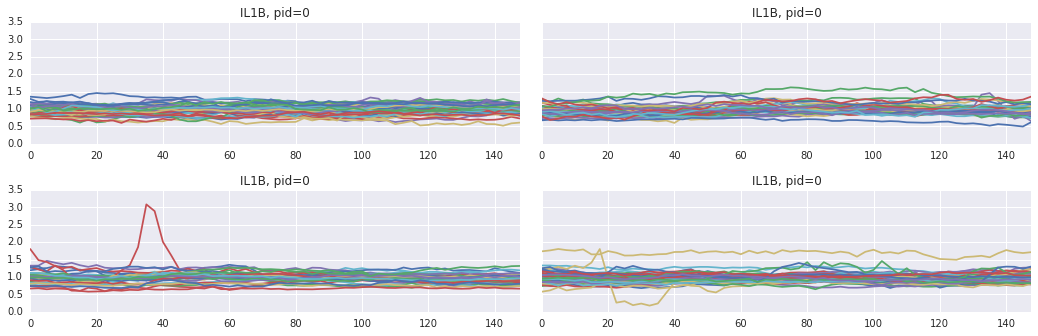

In [24]:
ops_plotter.plot_all(sites['cyto', 'YFP', 'median_ratio']);

We will only be using the average trace for the JNK AE mutant when we start modeling, so filter out traces with outliers and drastic changes that will skew the average.

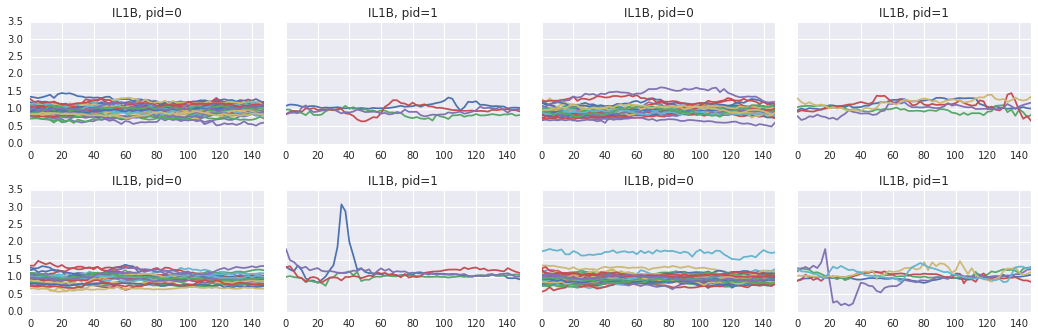

In [25]:
ops_bool.filter_frames_by_diff(sites['cyto', 'YFP', 'median_ratio'], THRES=0.15)
fig, axes = ops_plotter.plot_all(sites['cyto', 'YFP', 'median_ratio'])

In [26]:
sites.drop_prop(1)

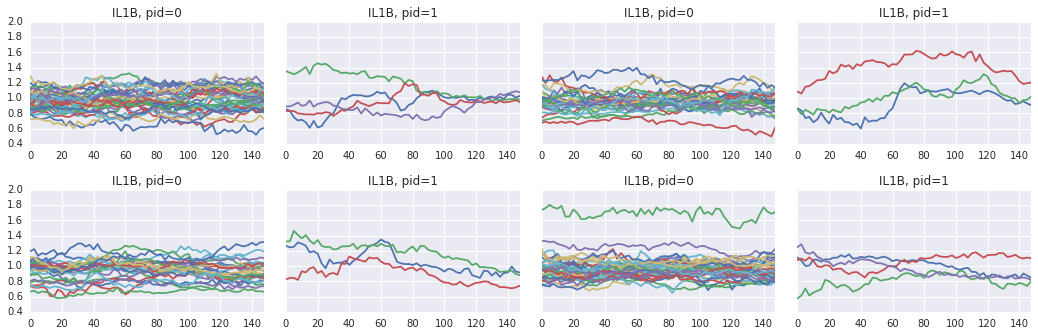

In [27]:
ops_bool.filter_frames_by_percentile_stats(sites['cyto', 'YFP', 'median_ratio'], func=np.nanstd, UPPER=90)
ops_plotter.plot_all(sites['cyto', 'YFP', 'median_ratio']);

In [28]:
sites.drop_prop(1)

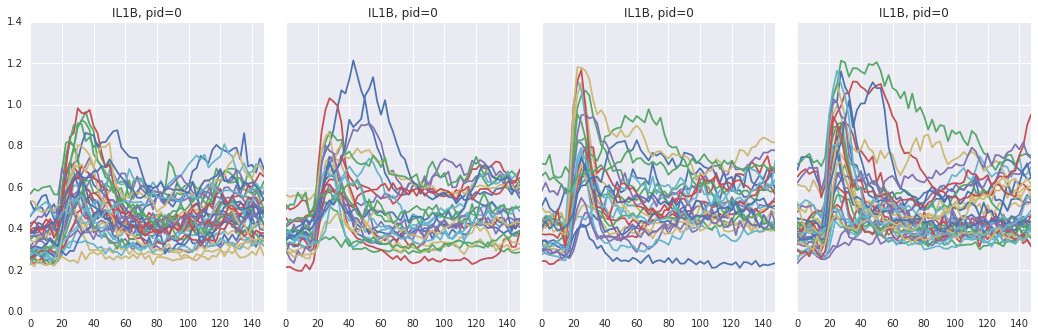

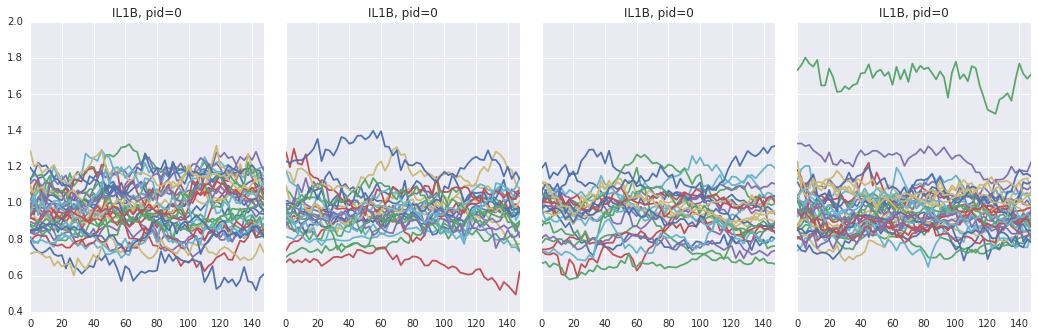

In [29]:
sites.canvas.num_row = 1
ops_plotter.plot_all(sites['cyto', 'TRITC', 'median_ratio']);
ops_plotter.plot_all(sites['cyto', 'YFP', 'median_ratio']);
ops_bool.cut_short_traces(sites['cyto', 'TRITC', 'median_ratio'], MINFRAME=60)
sites.save('df_cleaned.npz')

### Clean the second dataset: Anisomycin stimulation followed by JNK inhibitor

We are going to use the same process to clean the other datasets that we need.  
Now we will clean the dataset where the JNK KTR was activated with anisomycin and then inactivated with JNK inhibitor.  
This time we have only one position.

In [30]:
parent_folder = join(data_folder, 'AnisoInh')
sub_folders = ['Pos0']
conditions = ['AnisoInh']
sites_anis = Sites(parent_folder, sub_folders, conditions, file_name='df.npz')

In [31]:
sites_anis.Pos0.time = np.arange(29) * 5  # every 5 min
sites_anis.add_median_ratio()

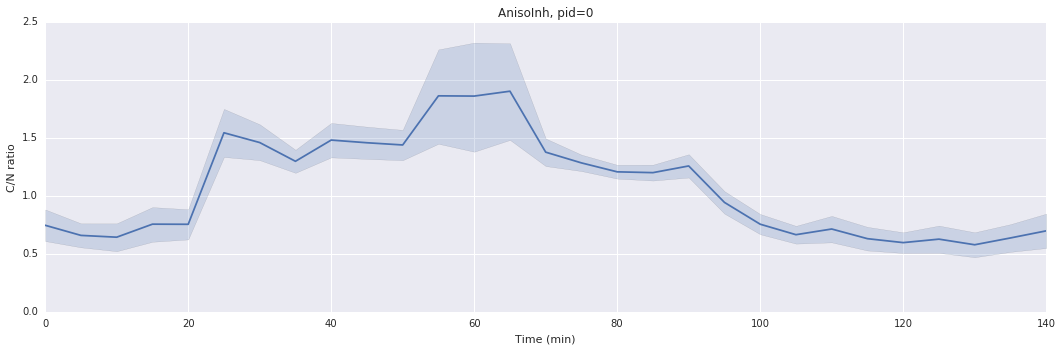

In [32]:
fig, axes = ops_plotter.plot_tsplot(sites_anis['cyto', 'YFP', 'median_ratio'])
[ax.set_xlabel('Time (min)') for ax in axes]
[ax.set_ylabel('C/N ratio') for ax in axes]

You can see the activation of JNK KTR followed by inhibition.

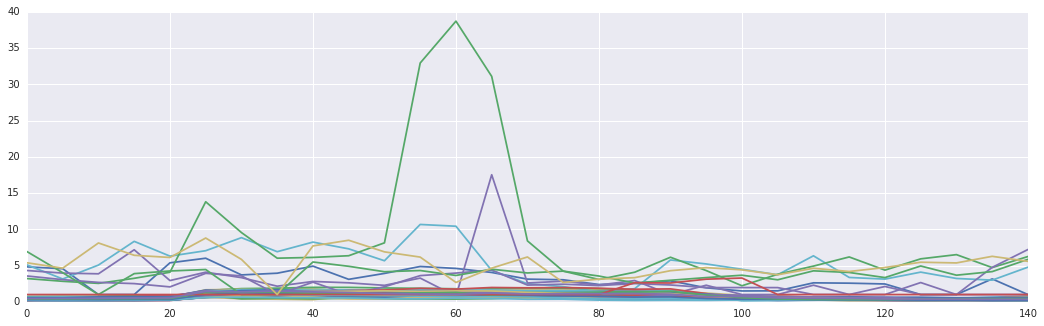

In [33]:
fig, axes = ops_plotter.plot_all(sites_anis.Pos0['cyto', 'YFP', 'median_ratio'])

Again, you see some outliers before cleaning.  
First remove cells without reporter expression.

[(34.0, 20000)]

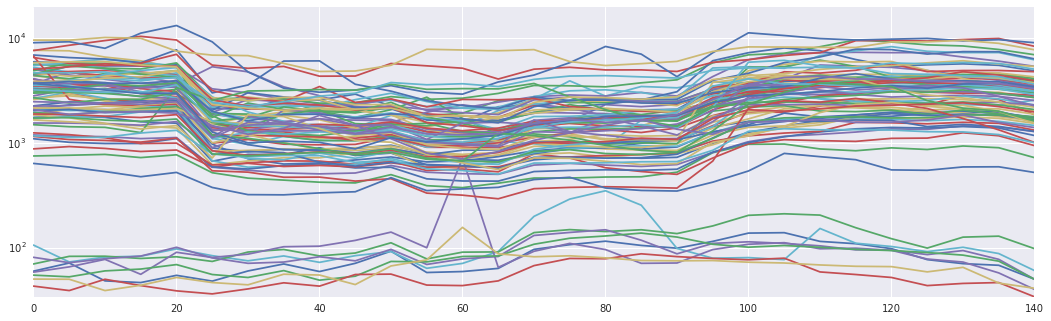

In [34]:
fig, axes = ops_plotter.plot_all(sites_anis.Pos0['nuc', 'YFP', 'median_intensity'], logy=True)
[ax.set_ylim([0, 20000]) for ax in axes]

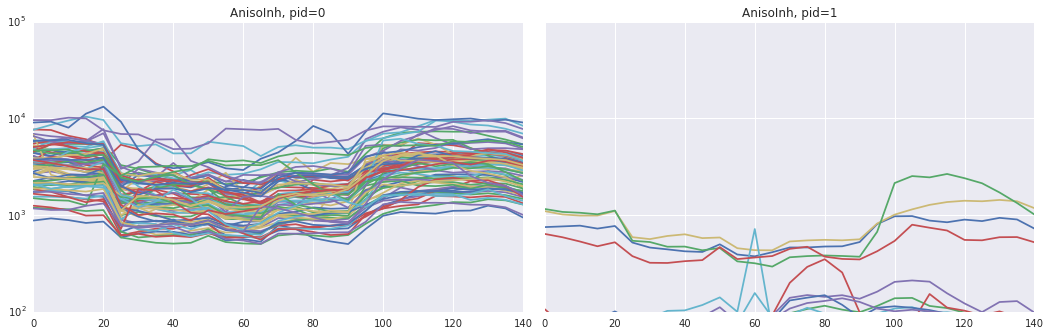

In [35]:
ops_bool.filter_frames_by_range(sites_anis['nuc', 'YFP', 'median_intensity'], LOWER=500)
fig, axes = ops_plotter.plot_all(sites_anis['nuc', 'YFP', 'median_intensity'], logy=True)

In [36]:
sites_anis.drop_prop(1)

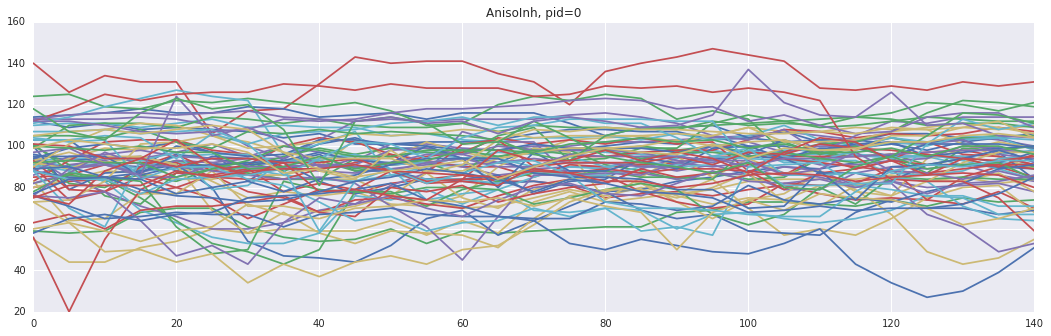

In [37]:
fig, axes = ops_plotter.plot_all(sites_anis['cyto', 'YFP', 'area'])

Drop cells which have less than 60 cytoplasmic pixels or more than 130 pixels.

In [38]:
ops_bool.filter_frames_by_range(sites_anis['cyto', 'YFP', 'area'], LOWER=60, UPPER=130)
sites_anis.drop_prop(1)

Detect sudden changes in nuclear area.

/opt/conda/lib/python2.7/site-packages/covertrace-0.1-py2.7.egg/covertrace/ops_bool.py:192: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=0,window=5,center=True).mean()


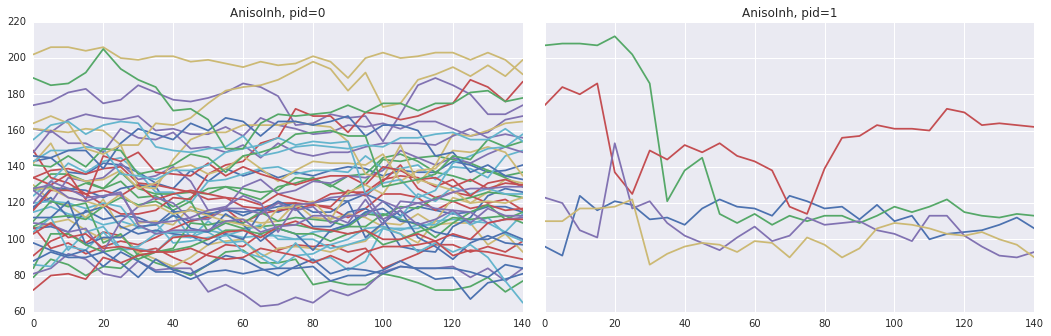

In [39]:
ops_bool.calc_rolling_func_filter(sites_anis['nuc', 'YFP', 'area'], threshold=15, window=5)
fig, axes = ops_plotter.plot_all(sites_anis['nuc', 'YFP', 'area'])

In [40]:
sites_anis.drop_prop(1)

Drop cells whose median intensity of either nuclei/cytoplasm are outside of the 10 to 95 percentile.

In [41]:
ops_bool.filter_frames_by_percentile_stats(sites_anis['cyto', 'YFP', 'median_intensity'], LOWER=10, UPPER=95)
ops_bool.filter_frames_by_percentile_stats(sites_anis['nuc', 'YFP', 'median_intensity'], LOWER=10, UPPER=95)
ops_bool.cut_short_traces(sites_anis['cyto', 'YFP', 'median_ratio'], MINFRAME=29)
sites_anis.drop_prop(1)

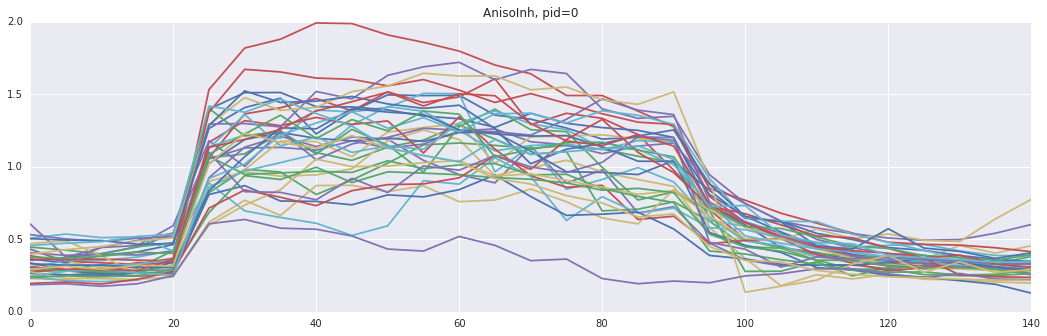

In [42]:
ops_plotter.plot_all(sites_anis['cyto', 'YFP', 'median_ratio']);
sites_anis.save('df_cleaned.npz')

### Clean the third dataset: Leptomycin B treatment of JNK KTR AA/EE mutants

We are going to use the same process to clean the final data set that we need. 
In this dataset, there are two positions. One is JNK KTR AA mutants and the another is JNK KTR EE mutants.  
Cells were treated with Leptomycin B (LMB) at 2 min and 28 min for JNK KTR AA mutants and JNK KTR EE mutants, respectively.

Here we see that the *sites* class can store multiple positions and conditions.

In [43]:
parent_folder_mut = join(data_folder, 'LMB')
sub_folders_mut = ['Pos004', 'Pos005']
conditions_mut = ['JNK_AA', 'JNK_EE']
sites_mut = Sites(parent_folder_mut, sub_folders_mut, conditions_mut, file_name='df.npz')
# Set time stamps.
sites_mut.Pos004.time = list(np.arange(0, 40) * 0.5)
sites_mut.Pos005.time = list(np.concatenate((np.arange(0, 28, 2), np.arange(28, 48.5, 0.5))))
sites_mut.add_median_ratio()

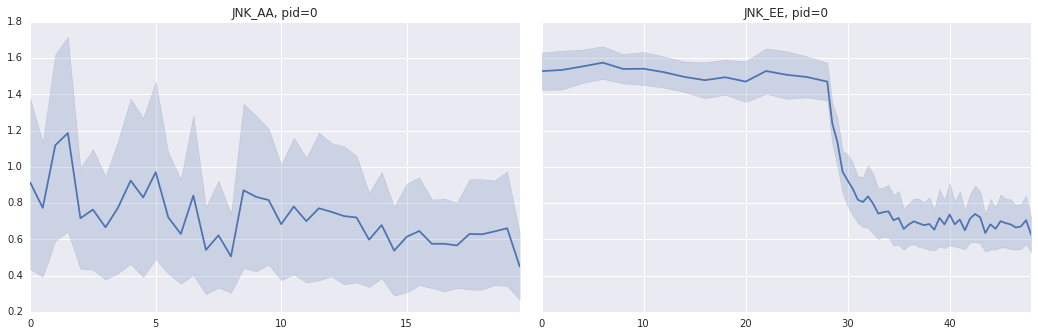

In [44]:
ops_plotter.plot_tsplot(sites_mut['cyto', 'YFP', 'median_ratio']);
axes[0].set_title('JNK KTR AA mutant')
axes[1].set_title('JNK KTR EE mutant')
axes[0].set_ylabel('C/N ratio')

The C/N ratio of JNK KTR EE mutants is almost equivalent to the active JNK KTR, indicating that it localizes to the cytoplasm more than JNK AA mutants do initially.  
After Leptomycin B treatment, you can see that inhibition of nuclear export leads to nuclear localization for both mutants.

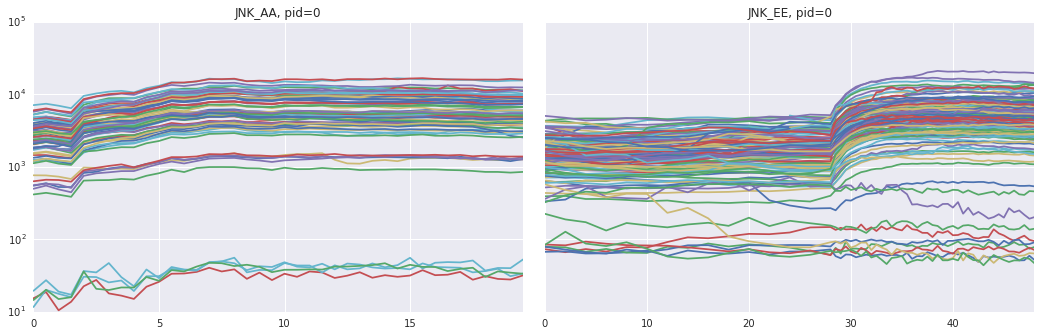

In [45]:
ops_plotter.plot_all(sites_mut['nuc', 'YFP', 'median_intensity'], logy=True);

Now we can again exclude cells with low reporter expression levels, small nuclear areas, and sudden changes in nuclear area.

In [46]:
ops_bool.filter_frames_by_range(sites_mut['nuc', 'YFP', 'median_intensity'], LOWER=750)
sites_mut.drop_prop(1)

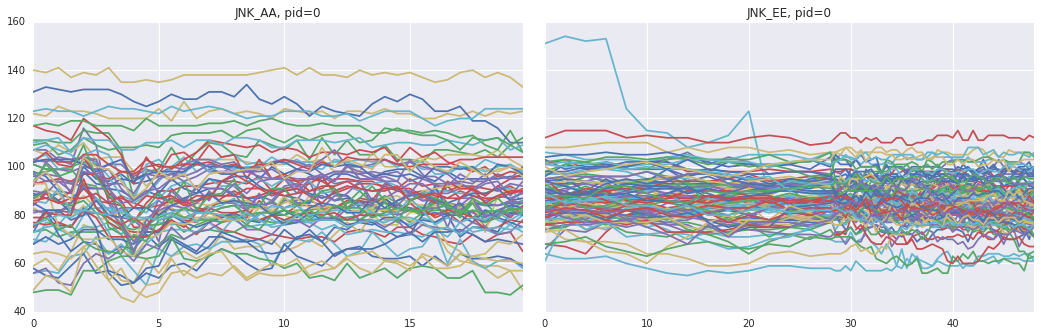

In [47]:
ops_plotter.plot_all(sites_mut['cyto', 'YFP', 'area']);

In [48]:
ops_bool.filter_frames_by_range(sites_mut['cyto', 'YFP', 'area'], LOWER=60, UPPER=130)
sites_mut.drop_prop(1)

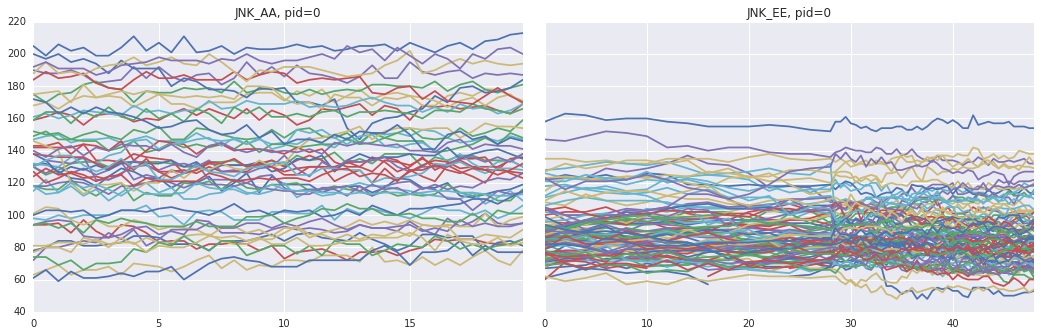

In [49]:
ops_plotter.plot_all(sites_mut['nuc', 'YFP', 'area']);

In [50]:
ops_bool.calc_rolling_func_filter(sites_mut['cyto', 'YFP', 'area'], threshold=15, window=5)
ops_bool.cut_short_traces(sites_mut.Pos004['cyto', 'YFP', 'median_ratio'], MINFRAME=40)
ops_bool.cut_short_traces(sites_mut.Pos005['cyto', 'YFP', 'median_ratio'], MINFRAME=55)
sites_mut.drop_prop(1)

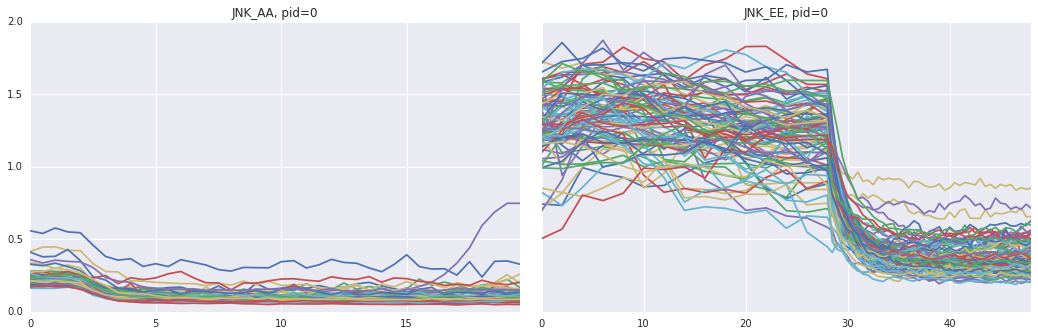

In [51]:
ops_plotter.plot_all(sites_mut['cyto', 'YFP', 'median_ratio']);

In [52]:
ops_bool.filter_frames_by_percentile_stats(sites_mut['cyto', 'YFP', 'median_intensity'], LOWER=10, UPPER=95)
ops_bool.filter_frames_by_percentile_stats(sites_mut['nuc', 'YFP', 'median_intensity'], LOWER=10, UPPER=95)
sites_mut.drop_prop(1)

The cleaned single-cell traces are noticeably less noisy than before.

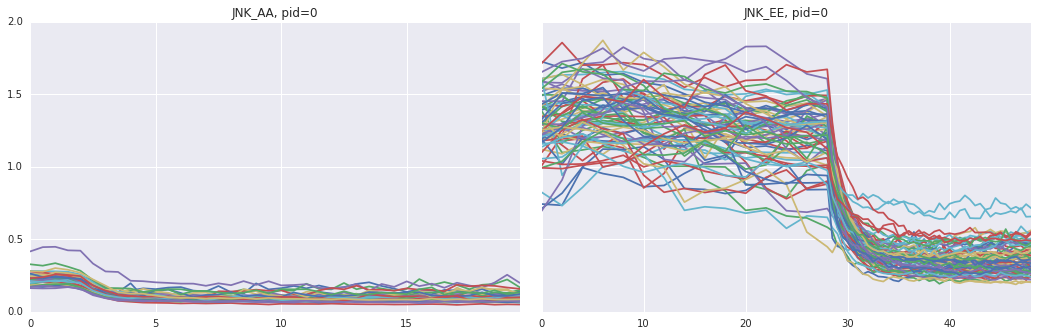

In [53]:
ops_plotter.plot_all(sites_mut['cyto', 'YFP', 'median_ratio']);
sites_mut.save('df_cleaned.npz')